In [1]:
rm(list=ls())
library(ggplot2)  #for plotting
library(corrplot) #for correlation plot
library(dplyr)    #for %in% function
library(caret)    #for cross validation
library(pscl)     #for Zero-inflated poisson regression
library(gridExtra)

path = 'C:\\github\\Project\\BikeSharing'
setwd(path)

train <- read.csv('train.csv', stringsAsFactors = F)
test <- read.csv('test.csv', stringsAsFactors = F)

corrplot 0.84 loaded

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis
Warning message:
"package 'gridExtra' was built under R version 3.5.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine



In [2]:
str(train)
str(test)

'data.frame':	10886 obs. of  12 variables:
 $ datetime  : chr  "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ count     : int  16 40 32 13 1 1 2 3 8 14 ...
'data.frame':	6493 obs. of  9 variables:
 $ datetime  : chr  "2011-01-20 0:00" "2011-01-20 1:00" "2011-01-20 2:00" "2011-01-20 3:00" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : int  1 1 1 1 1 1 1 1 1 2 ...
 $ temp      : num  10.7 10.7 10.7 10.7 10.7 

In [2]:
test$casual <- NA
test$registered <- NA
test$count <- NA

In [4]:
str(train)
str(test)

'data.frame':	10886 obs. of  12 variables:
 $ datetime  : chr  "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ count     : int  16 40 32 13 1 1 2 3 8 14 ...
'data.frame':	6493 obs. of  12 variables:
 $ datetime  : chr  "2011-01-20 0:00" "2011-01-20 1:00" "2011-01-20 2:00" "2011-01-20 3:00" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : int  1 1 1 1 1 1 1 1 1 2 ...
 $ temp      : num  10.7 10.7 10.7 10.7 10.7

### Checking NA value

In [5]:
print(colSums(is.na(train)))

  datetime     season    holiday workingday    weather       temp      atemp 
         0          0          0          0          0          0          0 
  humidity  windspeed     casual registered      count 
         0          0          0          0          0 


In [6]:
print(colSums(is.na(test)))

  datetime     season    holiday workingday    weather       temp      atemp 
         0          0          0          0          0          0          0 
  humidity  windspeed     casual registered      count 
         0          0       6493       6493       6493 


->  There is no NA value!

### Preparing total data
- merging for data preprocessing

In [3]:
train <- rename(train, 'y' = 'count')
test <- rename(test, 'y' = 'count')
data <- rbind(train, test)
str(data)

'data.frame':	17379 obs. of  12 variables:
 $ datetime  : chr  "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ workingday: int  0 0 0 0 0 0 0 0 0 0 ...
 $ weather   : int  1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ y         : int  16 40 32 13 1 1 2 3 8 14 ...


## EDA

In [4]:
#진행하기 앞서, Factor 변수들을 변환
data$season <- factor(data$season)
data$holiday <- factor(data$holiday)
data$workingday <- factor(data$workingday)
data$weather <- factor(data$weather)

In [8]:
str(data)

'data.frame':	17379 obs. of  12 variables:
 $ datetime  : chr  "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00" ...
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ y         : int  16 40 32 13 1 1 2 3 8 14 ...


In [10]:
colnames(data)

[1] "datetime"   "season"     "holiday"    "workingday" "weather"   
 [6] "temp"       "atemp"      "humidity"   "windspeed"  "casual"    
[11] "registered" "y"

In [6]:
setequal(train$registered + train$casual, train$y)

[1] TRUE

**EDA를 진행하기 앞서, 모형을 2개로 나누어 예측하도록 한다!!**
- registered(등록자 대여) + casual(비등록자 대여) == y (전체 대여)
- 즉, 각각을 따로 예측하는 방안을 생각한다.

### 1. datetime : 날짜 + 시간의 구조

Warning message:
"Removed 6493 rows containing missing values (geom_point)."

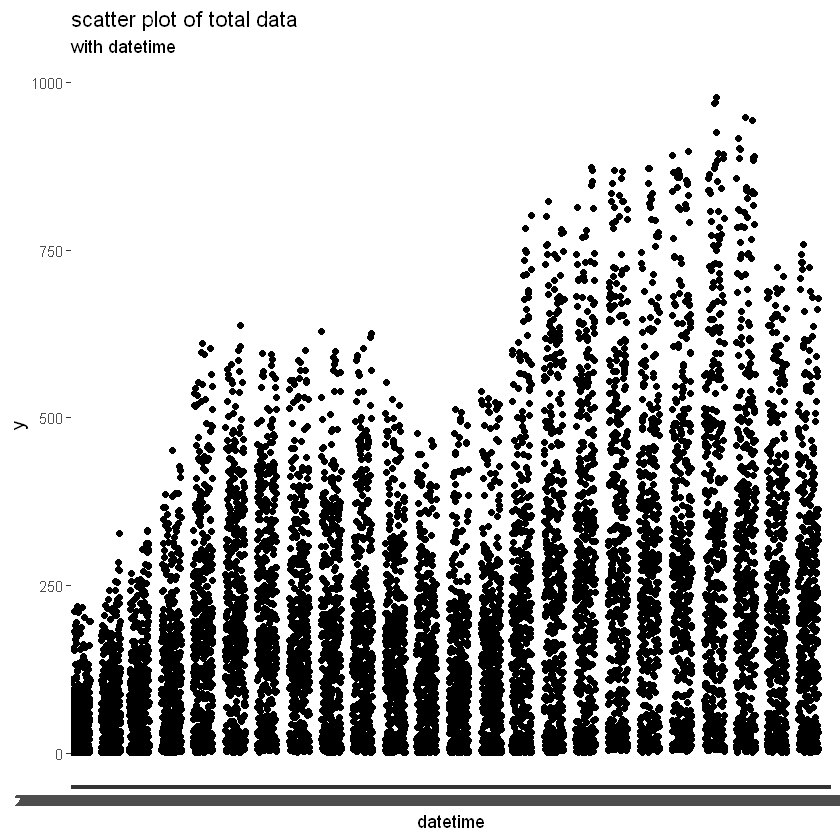

In [8]:
ggplot(data = data, aes(x = datetime, y = y)) +
    geom_point() +
    labs(title = 'scatter plot of total data',
        subtitle = 'with datetime')

1~20 일까지의 데이터 : train, 21~ 의 데이터 : test 인 것을 확인할 수 있다.
+ 시계열성 확인

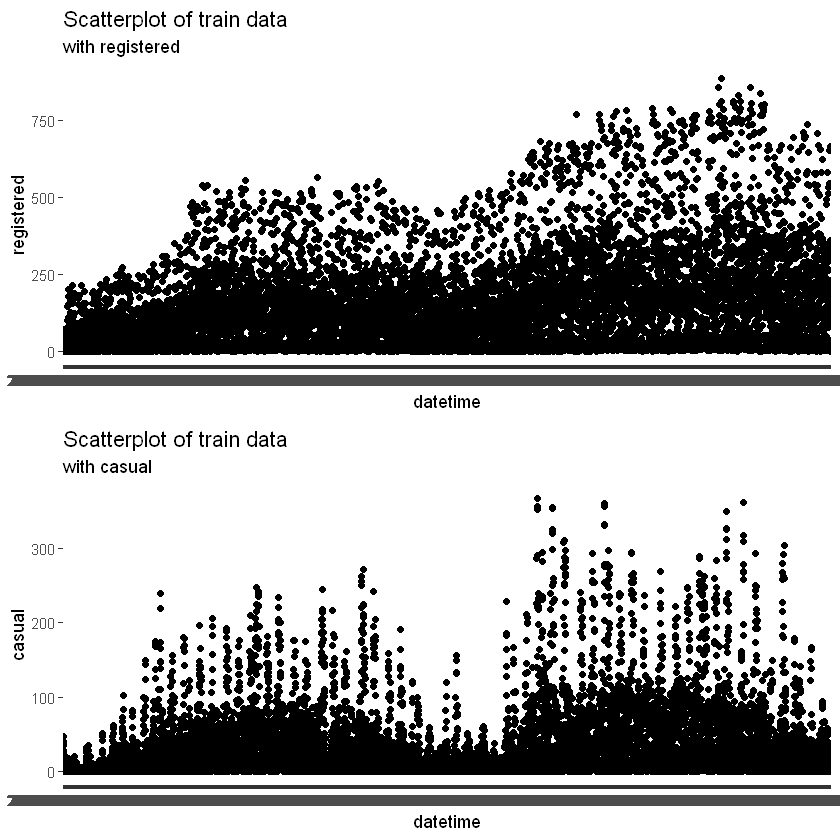

In [12]:
plot_registered <- ggplot(data = train, aes(x = datetime, y = registered)) +
    geom_point() +
    labs(title = 'Scatterplot of train data',
        subtitle = 'with registered')
plot_casual <- ggplot(data = train, aes(x = datetime, y = casual)) +
    geom_point() + 
    labs(title = 'Scatterplot of train data',
        subtitle = 'with casual')
grid.arrange(plot_registered, plot_casual, nrow = 2)

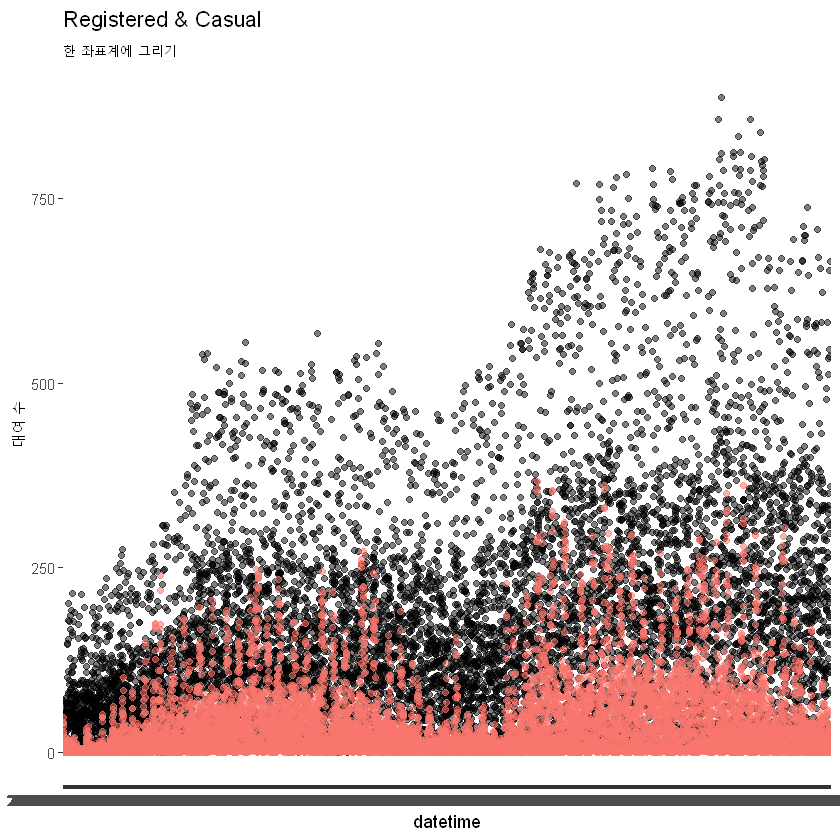

In [13]:
ggplot(data = train, aes(x = datetime, y = registered)) +
    geom_point(alpha = 0.5) + 
    geom_point(aes(x = datetime, y = casual, colour = 'red', alpha = 0.5)) +
    labs(title = 'Registered & Casual',
        subtitle = '한 좌표계에 그리기',
        y = '대여 수') +
    theme(legend.position = 'none') #불필요한 범례 삭제

2개의 Y의 세부변수(registered, casual)이 각기 다른 모양을 갖고 있는 것을 알 수 있다.

** Parsing datetime variable **
- datetime 변수에는 연, 월, 일, 시간 변수가 각각 존재한다.
- 시점에 강한 영향을 받는 것을 확인할 수 있다.
- 시간 / 시점(시작일로부터 지난 날 수) 2가지의 변수로 쪼갤 수 있을것 같다.

In [14]:
head(data$datetime)

[1] "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00"
[5] "2011-01-01 4:00" "2011-01-01 5:00"

In [15]:
head(unlist(strsplit(data$datetime, ' ')))

[1] "2011-01-01" "0:00"       "2011-01-01" "1:00"       "2011-01-01"
[6] "2:00"

In [5]:
split_idx <- seq(from = 2, to = nrow(data)*2, by = 2)

In [6]:
time <- unlist(strsplit(data$datetime, ' '))[split_idx]
day <- unlist(strsplit(data$datetime, ' '))[split_idx-1]

In [7]:
time <- ((as.integer(gsub(":", "" , time, perl=TRUE)) + 100) / 100) - 1 #00시의 존재로, 100을 더한뒤 나눠준 다음 1을 뺀다.
data$time <- as.factor(time)

day <- as.integer(gsub("-", "" , day, perl=TRUE))
data$day <- as.numeric(factor(rank(day))) #일시를 단순한 순서로 변경
str(data)

'data.frame':	17379 obs. of  14 variables:
 $ datetime  : chr  "2011-01-01 0:00" "2011-01-01 1:00" "2011-01-01 2:00" "2011-01-01 3:00" ...
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ y         : int  16 40 32 13 1 1 2 3 8 14 ...
 $ time      : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ day       : num  1 1 1 1 1 1 1 1 1 1 ...


Parsing이 제대로 되었는지 plot을 통하여 확인.

In [17]:
ggplot(data = data, aes(x = day, y = registered)) +
                geom_point(alpha = 0.5) + 
                geom_point(aes(x = day, y = casual, colour = 'red', alpha = 0.5)) +
                labs(title = 'Registered & Casual',
                    subtitle = '한 좌표계에 그리기',
                    y = '대여 수') +
                theme(legend.position = 'none') #불필요한 범례 삭제

Warning message:
"Removed 6493 rows containing missing values (geom_point)."Warning message:
"Removed 6493 rows containing missing values (geom_point)."

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): png() 장치를 시작할 수 없습니다


plot without title

In [18]:
plot(data$day, data$registered)

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): png() 장치를 시작할 수 없습니다


plot without title

날짜로 찍은 산점도와 일치하는 모습.

In [21]:
head(filter(data, time == 0))

datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y,time,day
2011-01-01 0:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,0,1
2011-01-02 0:00,1,0,0,2,18.86,22.725,88,19.9995,4,13,17,0,2
2011-01-03 0:00,1,0,1,1,9.02,9.850,44,23.9994,0,5,5,0,3
2011-01-04 0:00,1,0,1,1,6.56,9.090,55,7.0015,0,5,5,0,4
2011-01-05 0:00,1,0,1,1,8.20,12.880,64,0.0000,0,6,6,0,5
2011-01-06 0:00,1,0,1,1,7.38,12.120,55,0.0000,0,11,11,0,6


Warning message:
"Removed 271 rows containing missing values (geom_point)."Warning message:
"Removed 271 rows containing missing values (geom_point)."Warning message:
"Removed 270 rows containing missing values (geom_point)."Warning message:
"Removed 270 rows containing missing values (geom_point)."

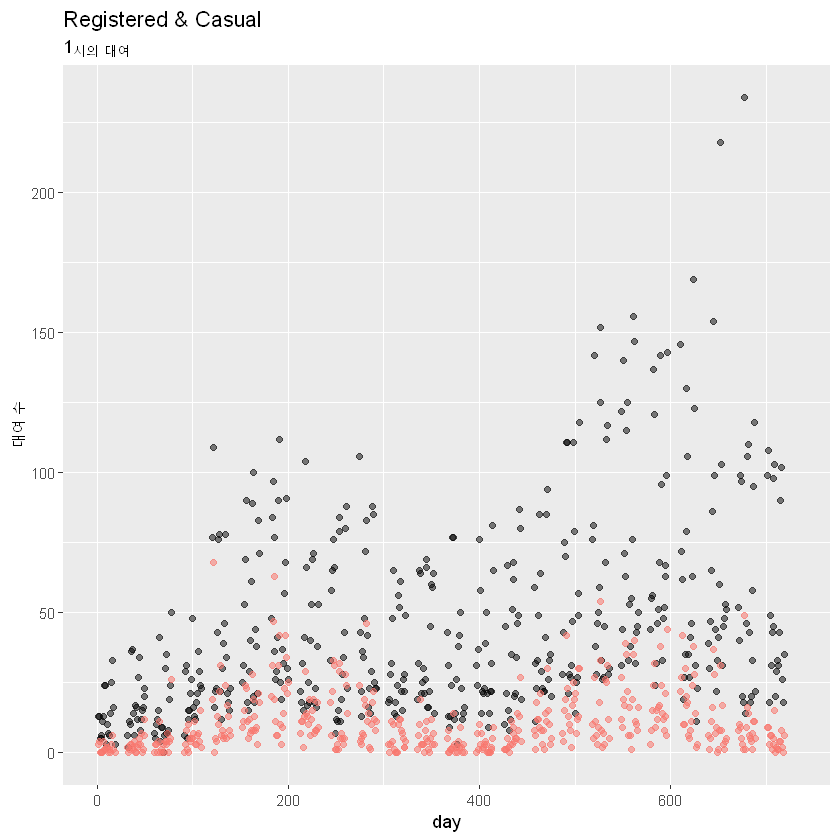

Warning message:
"Removed 267 rows containing missing values (geom_point)."Warning message:
"Removed 267 rows containing missing values (geom_point)."

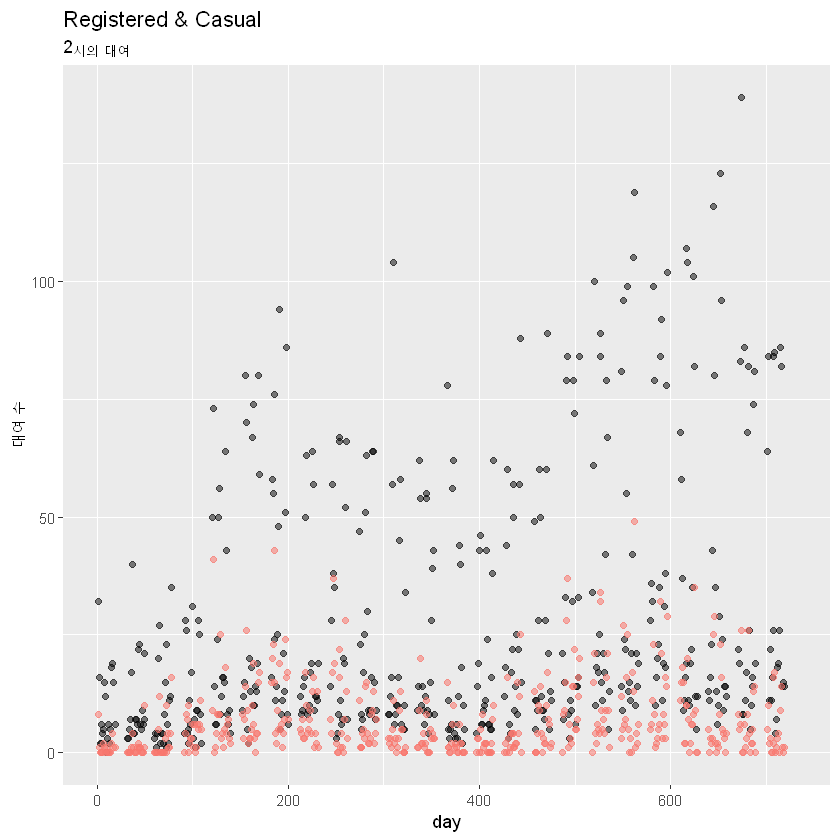

Warning message:
"Removed 264 rows containing missing values (geom_point)."Warning message:
"Removed 264 rows containing missing values (geom_point)."

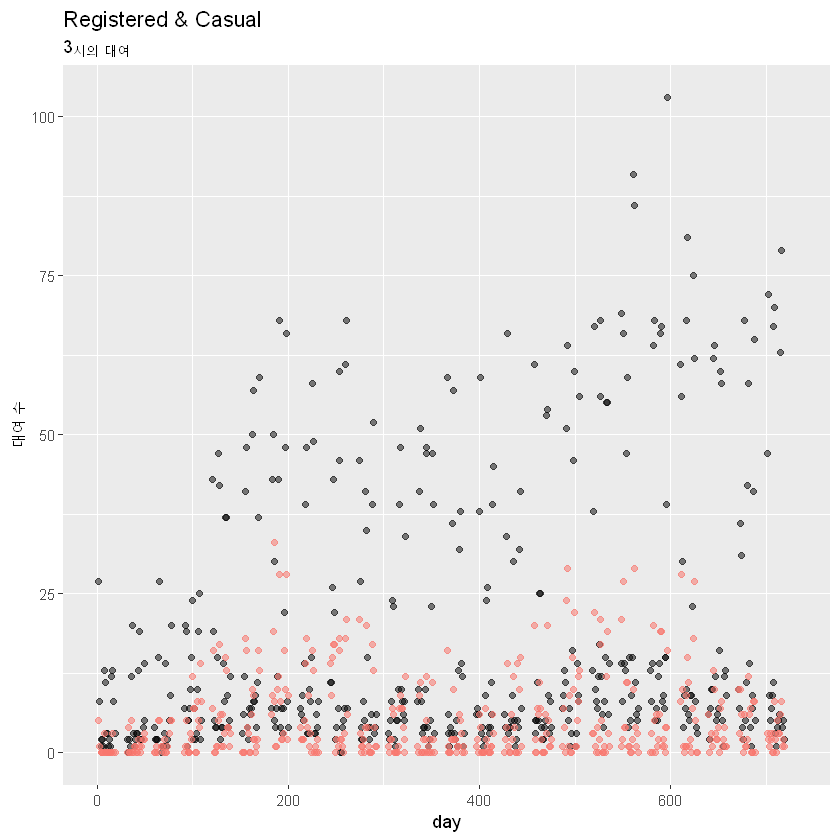

Warning message:
"Removed 255 rows containing missing values (geom_point)."Warning message:
"Removed 255 rows containing missing values (geom_point)."

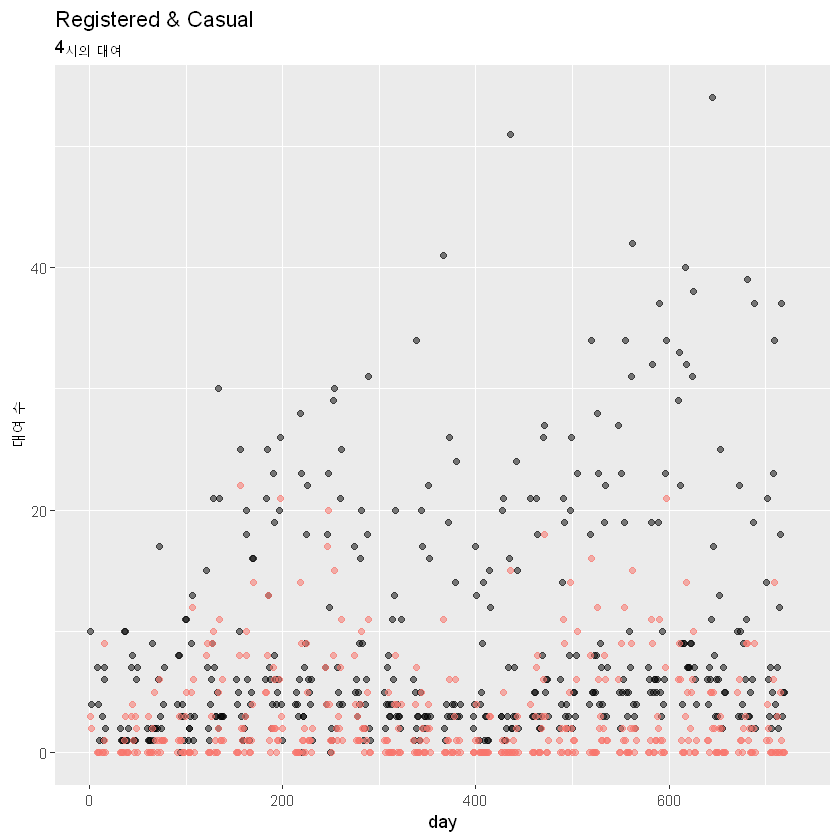

Warning message:
"Removed 265 rows containing missing values (geom_point)."Warning message:
"Removed 265 rows containing missing values (geom_point)."

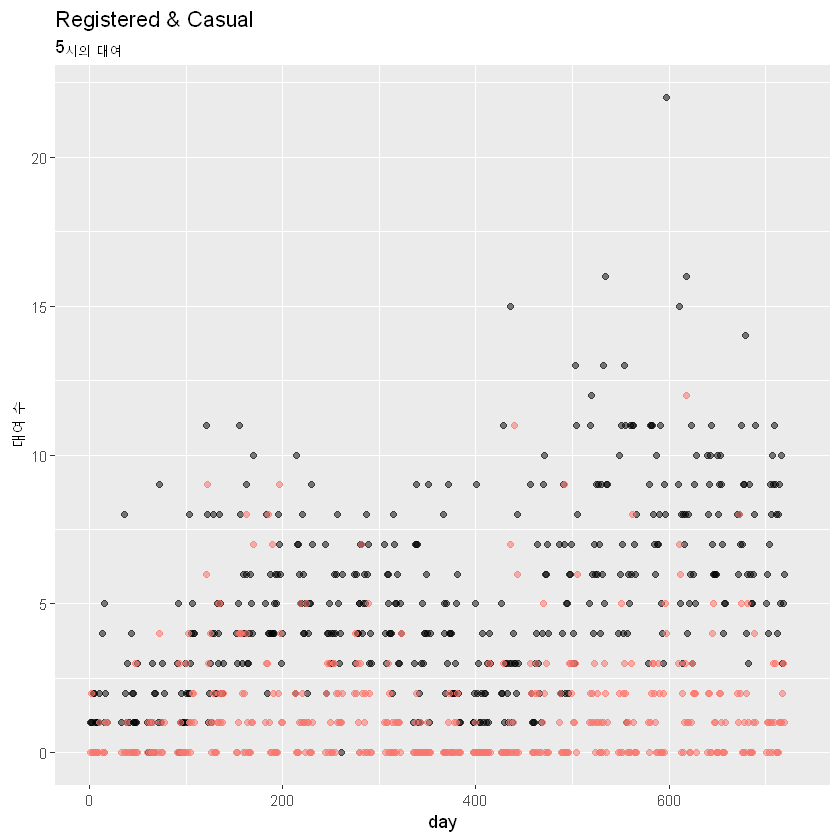

Warning message:
"Removed 270 rows containing missing values (geom_point)."Warning message:
"Removed 270 rows containing missing values (geom_point)."

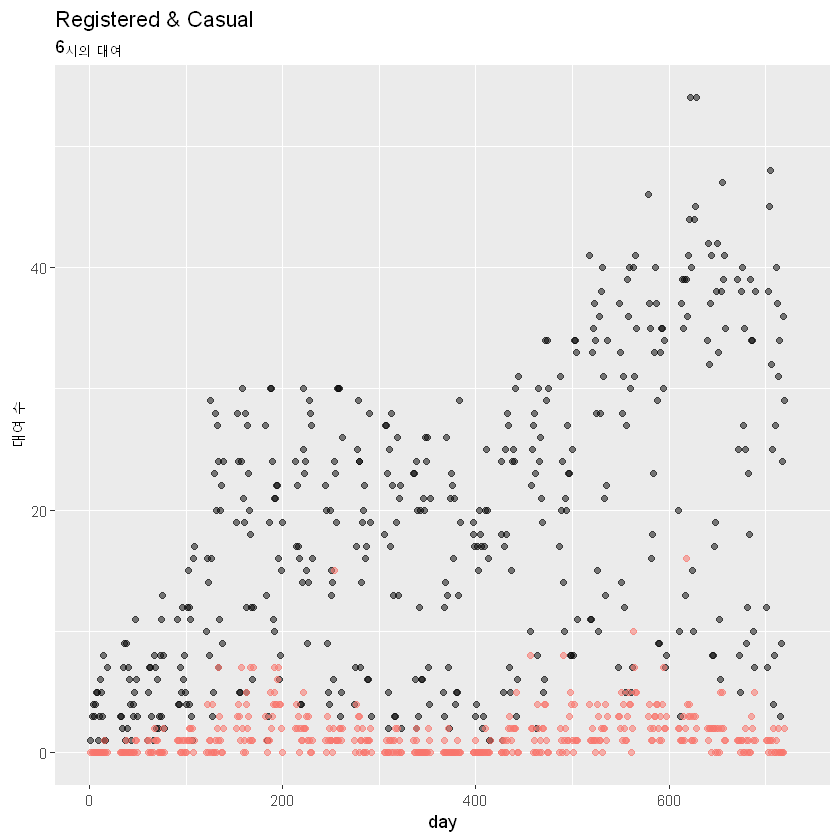

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

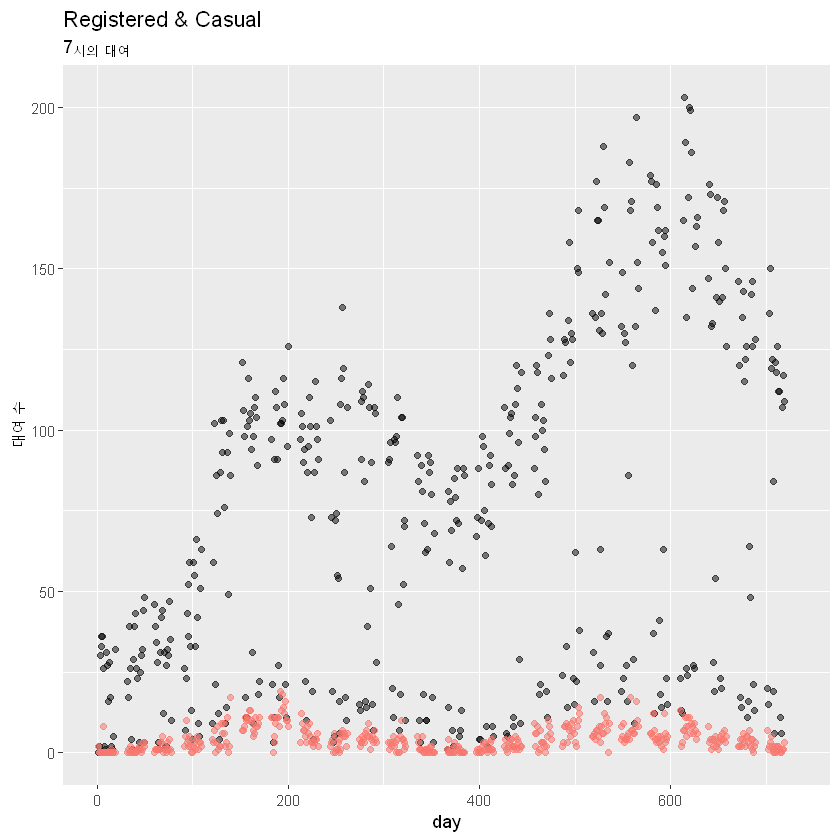

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

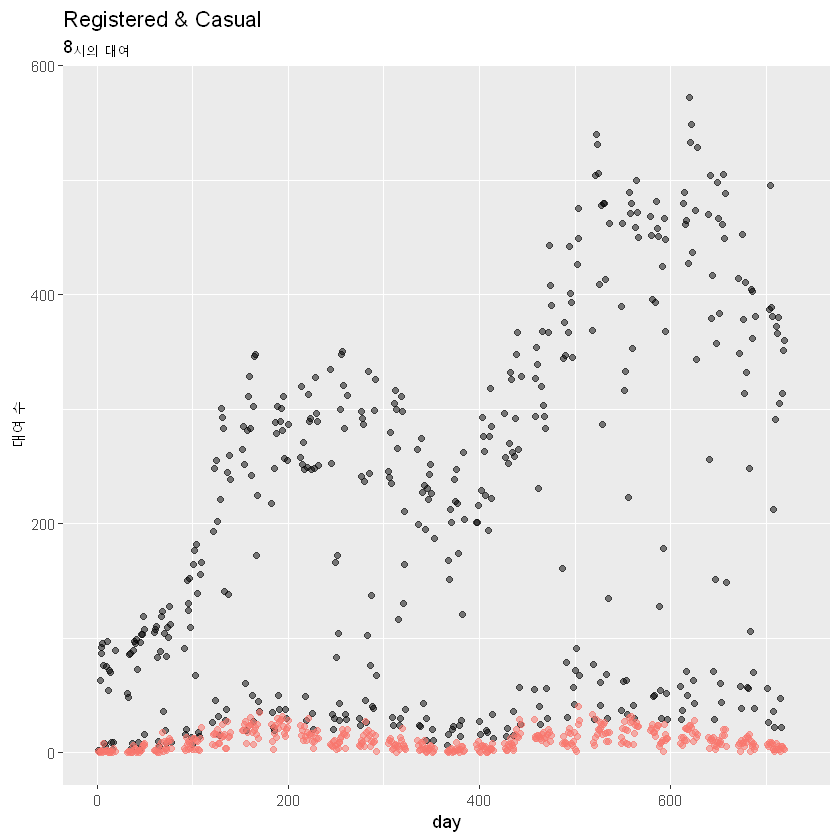

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

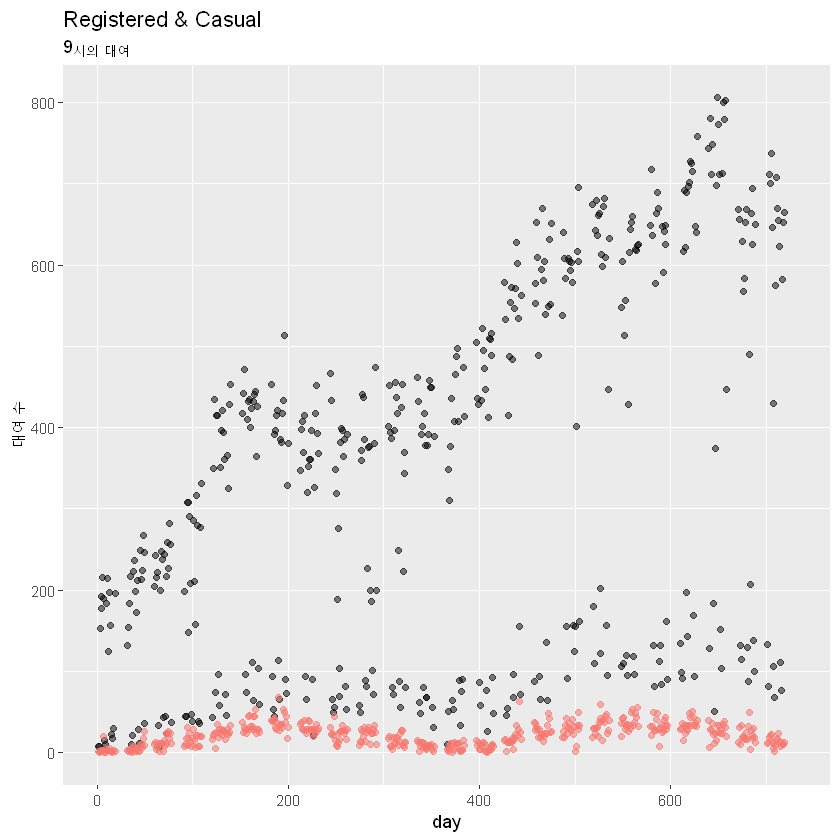

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

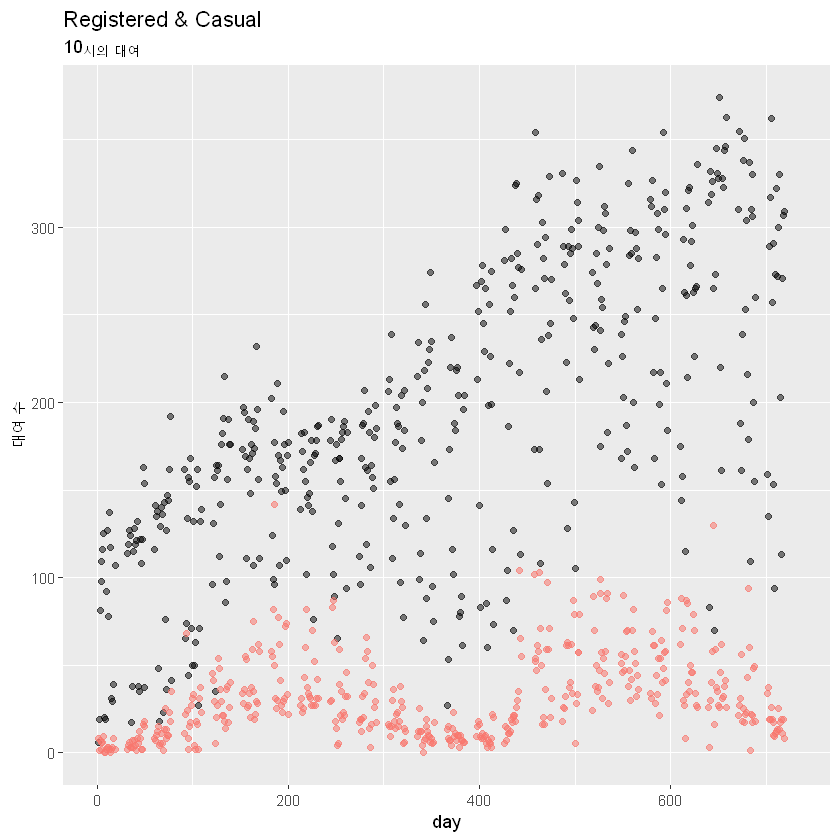

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

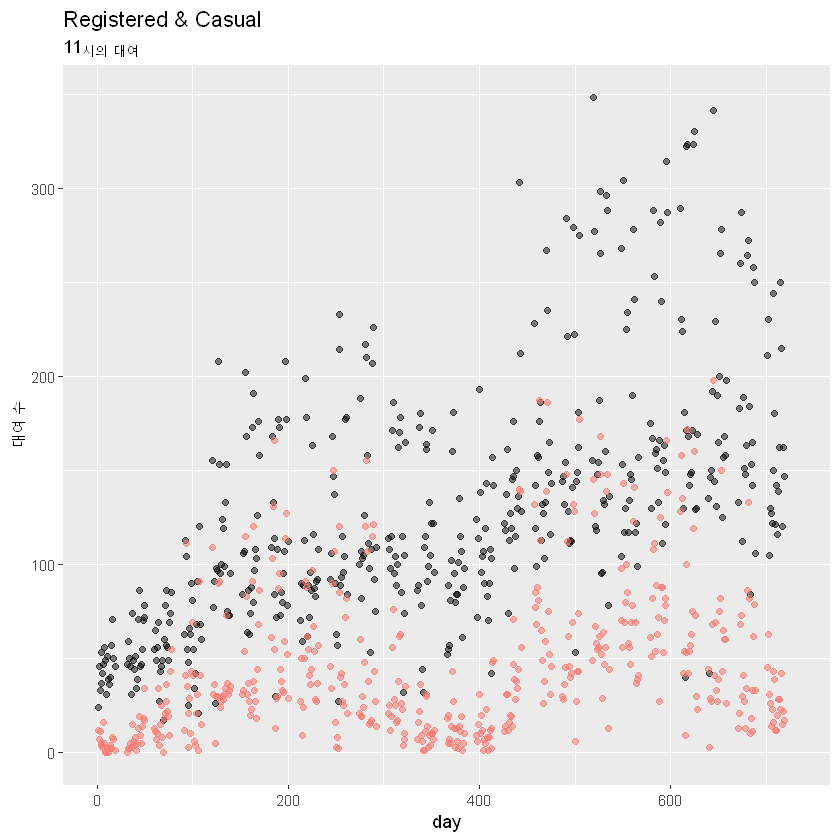

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

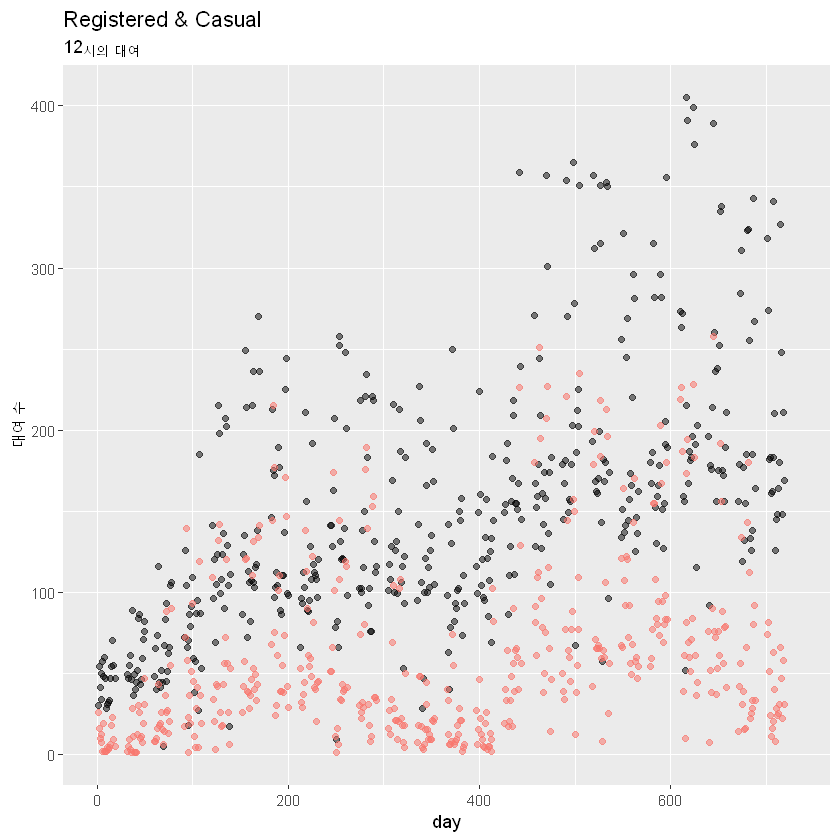

Warning message:
"Removed 273 rows containing missing values (geom_point)."Warning message:
"Removed 273 rows containing missing values (geom_point)."

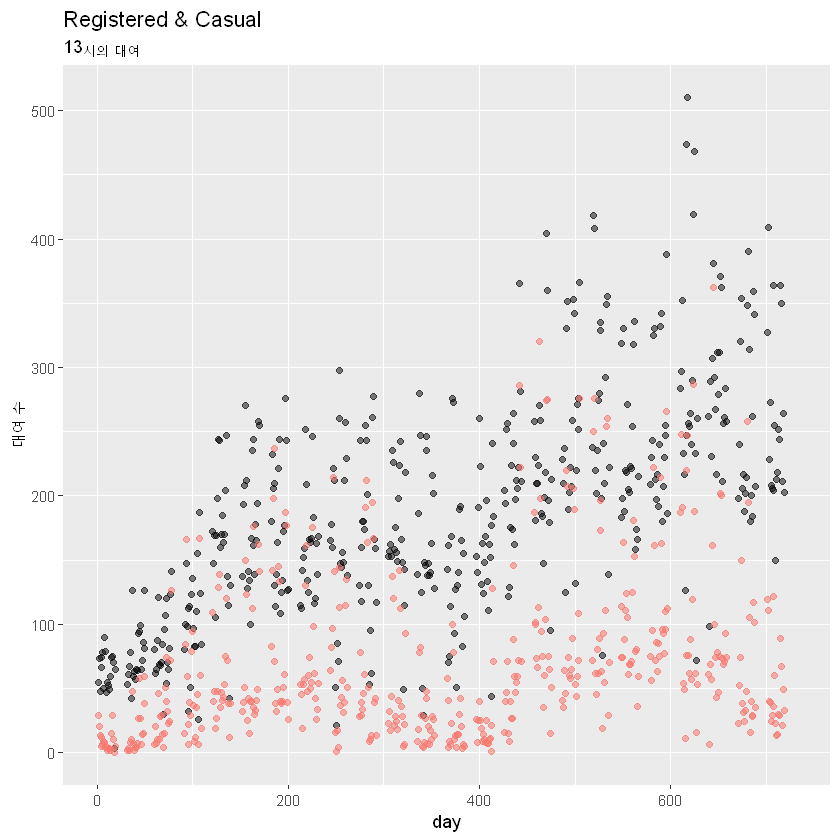

Warning message:
"Removed 273 rows containing missing values (geom_point)."Warning message:
"Removed 273 rows containing missing values (geom_point)."

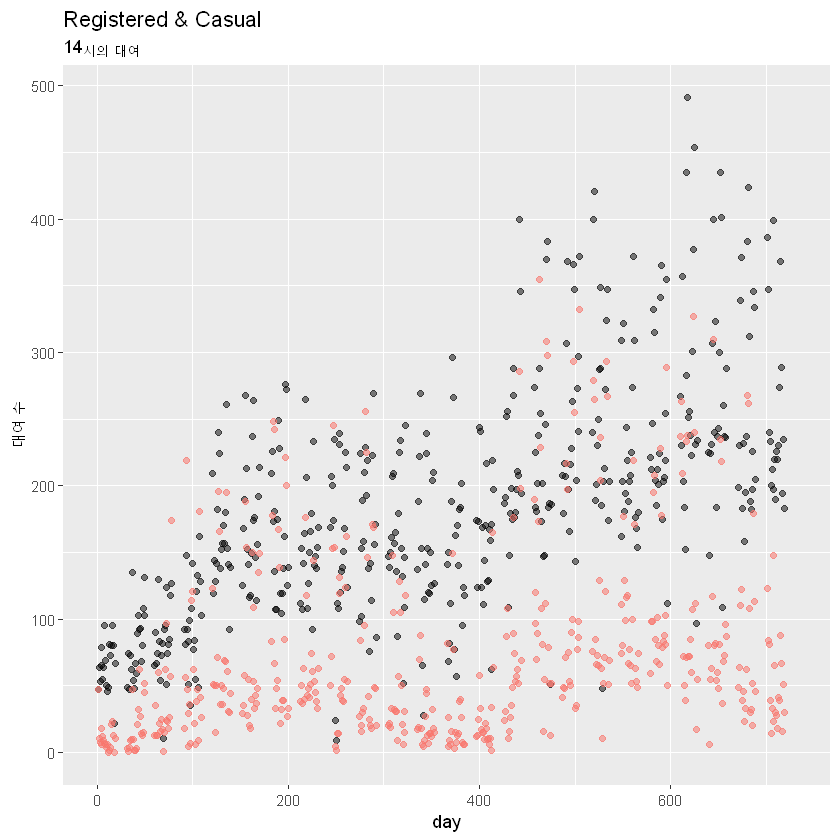

Warning message:
"Removed 273 rows containing missing values (geom_point)."Warning message:
"Removed 273 rows containing missing values (geom_point)."

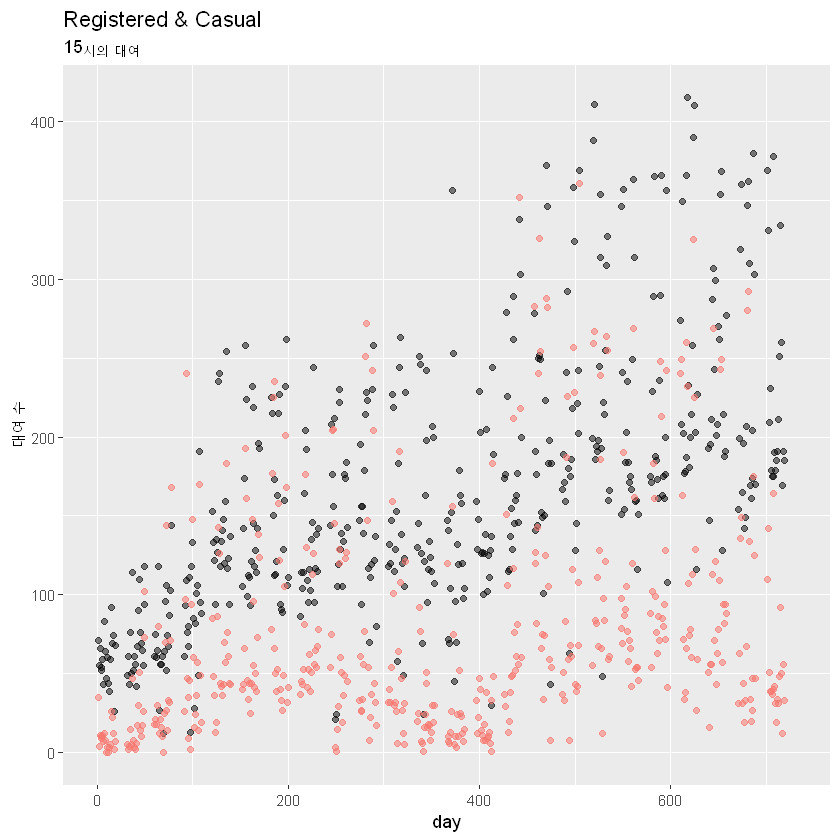

Warning message:
"Removed 274 rows containing missing values (geom_point)."Warning message:
"Removed 274 rows containing missing values (geom_point)."

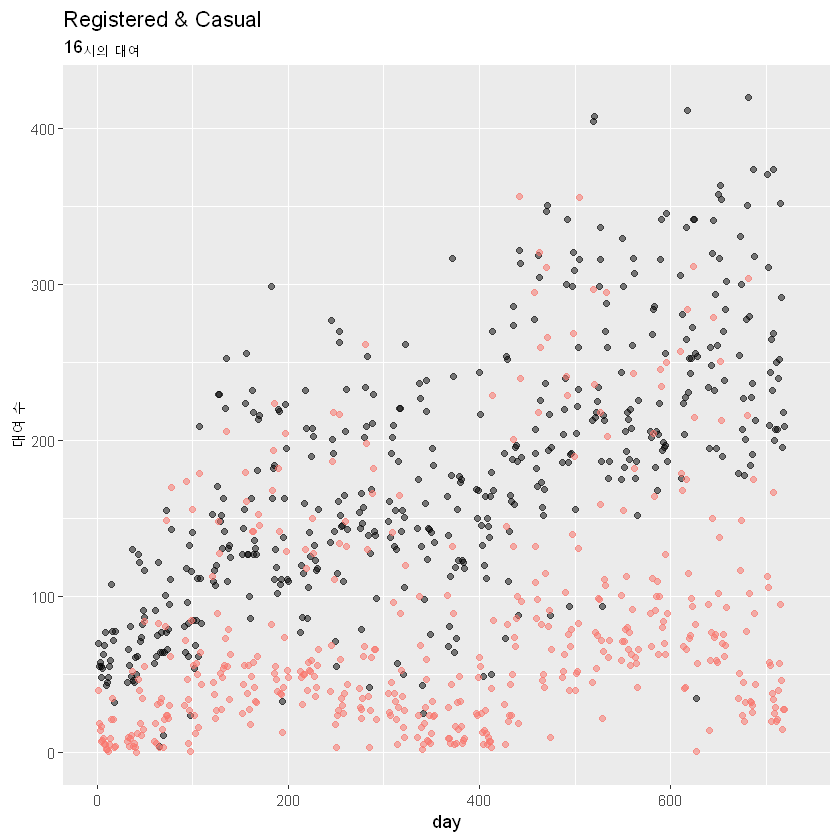

Warning message:
"Removed 274 rows containing missing values (geom_point)."Warning message:
"Removed 274 rows containing missing values (geom_point)."

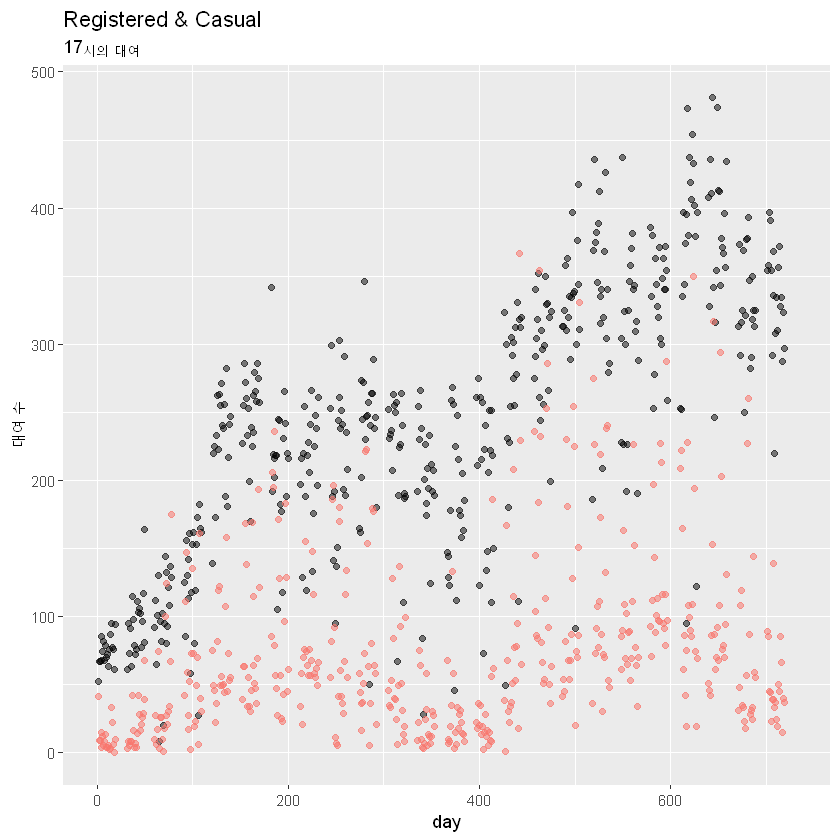

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

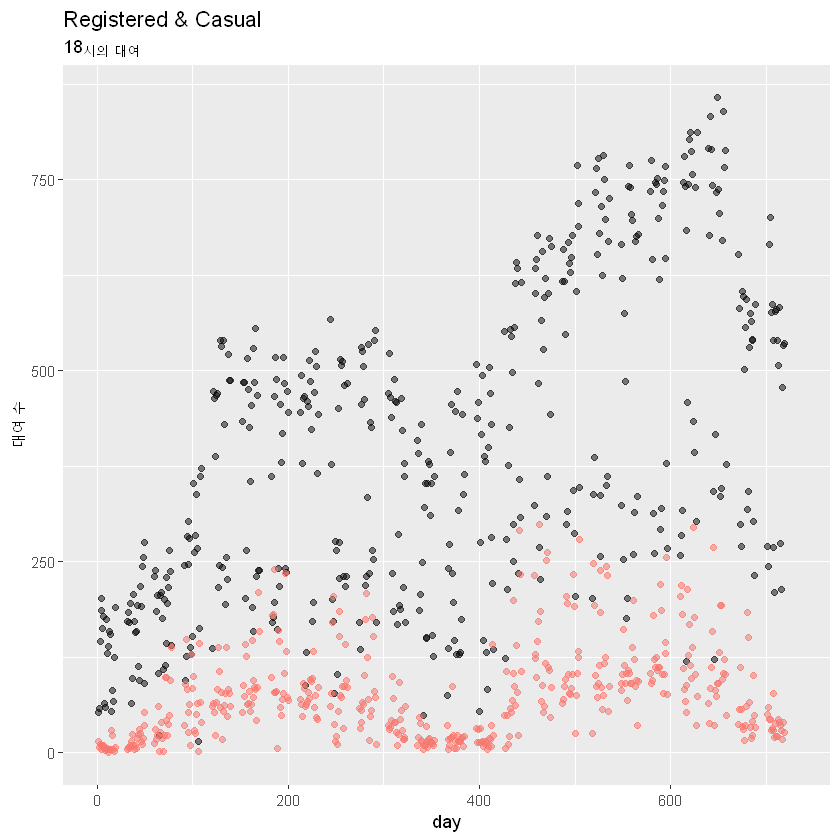

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

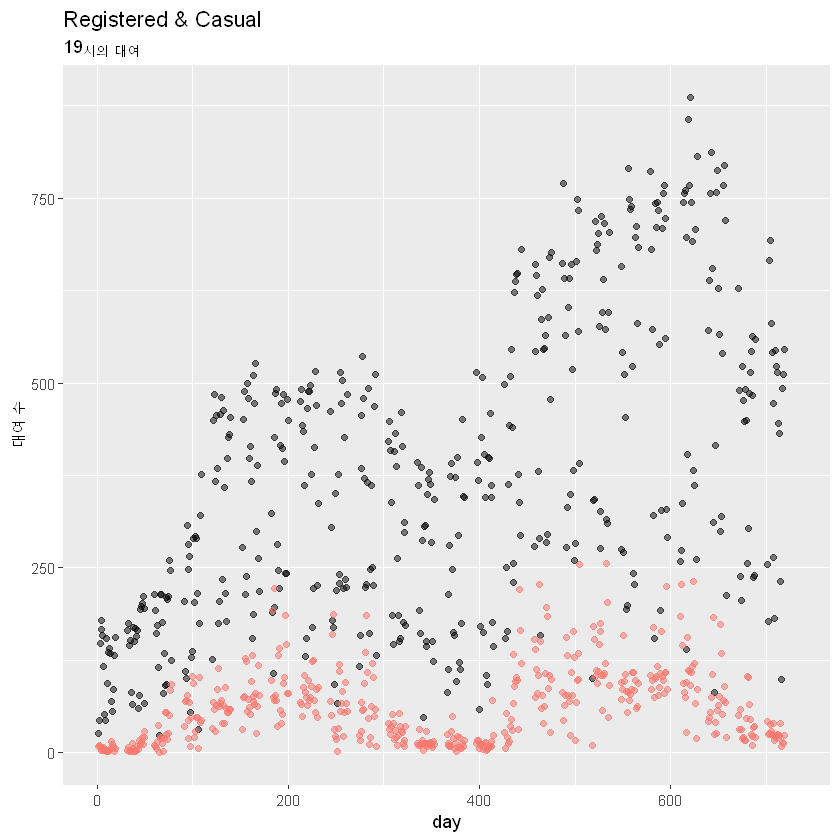

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

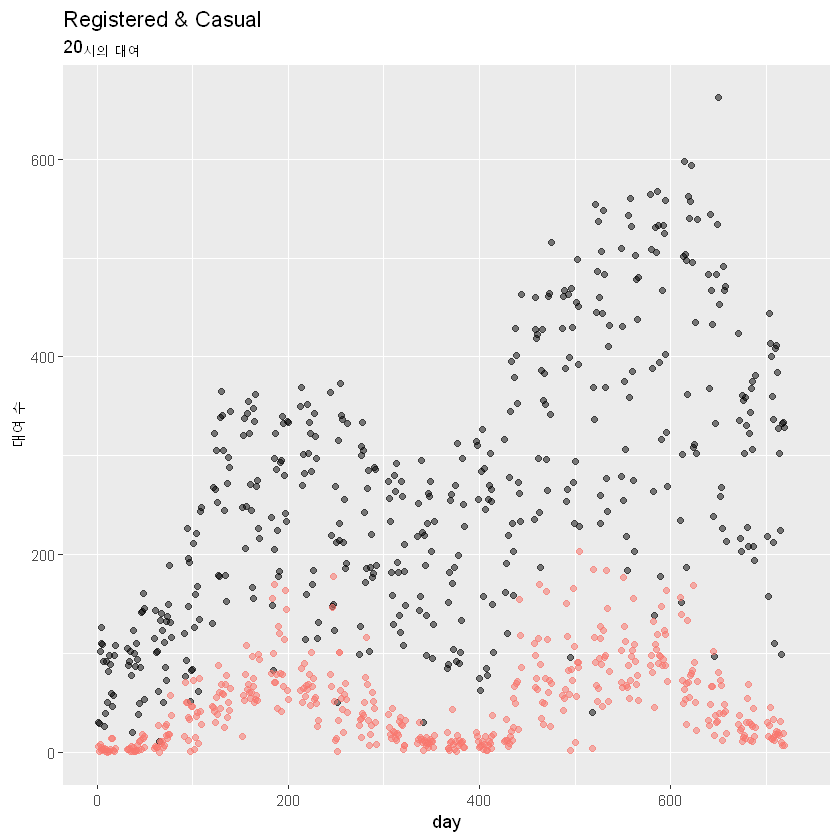

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

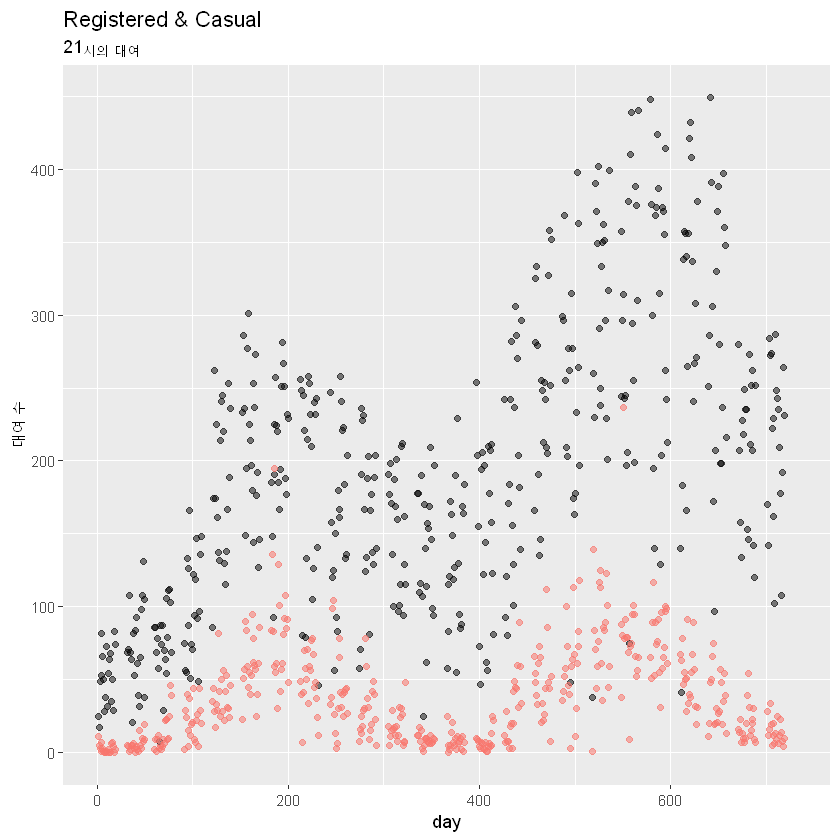

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

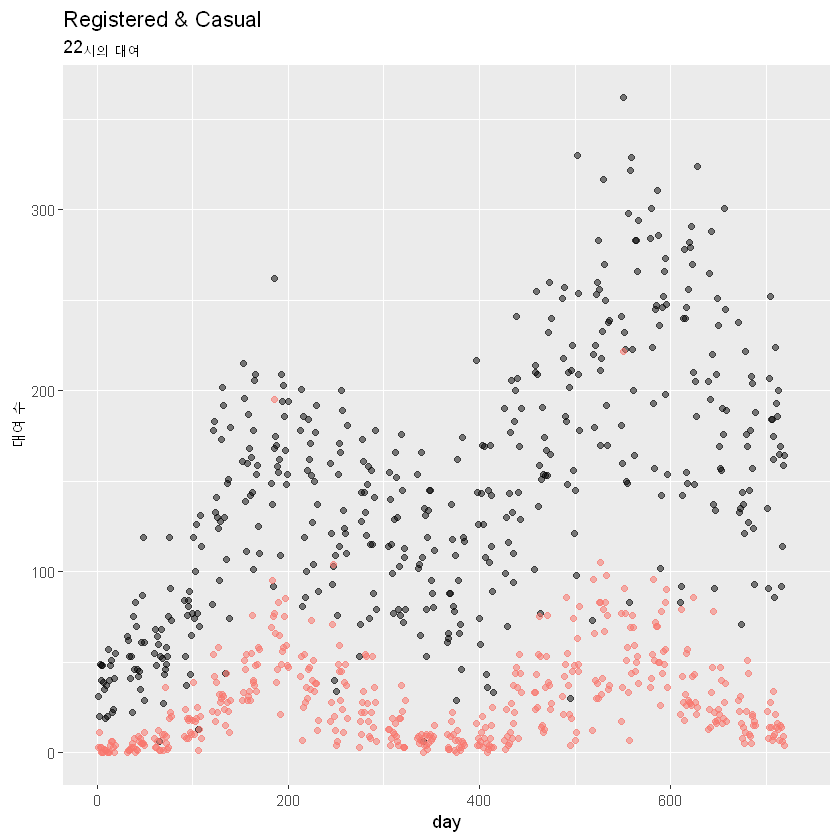

Warning message:
"Removed 272 rows containing missing values (geom_point)."Warning message:
"Removed 272 rows containing missing values (geom_point)."

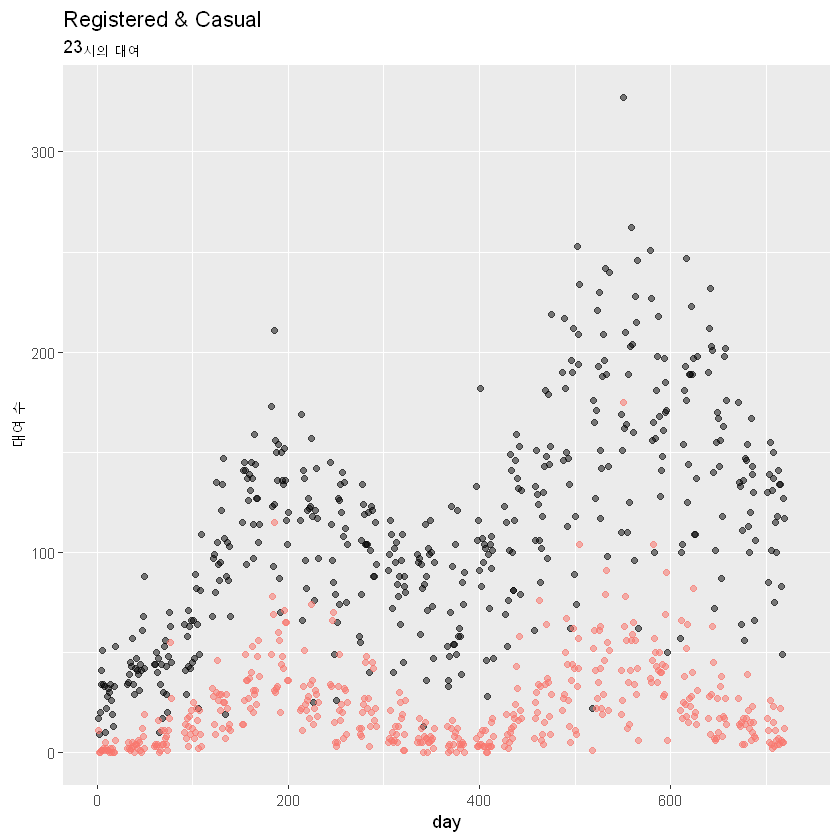

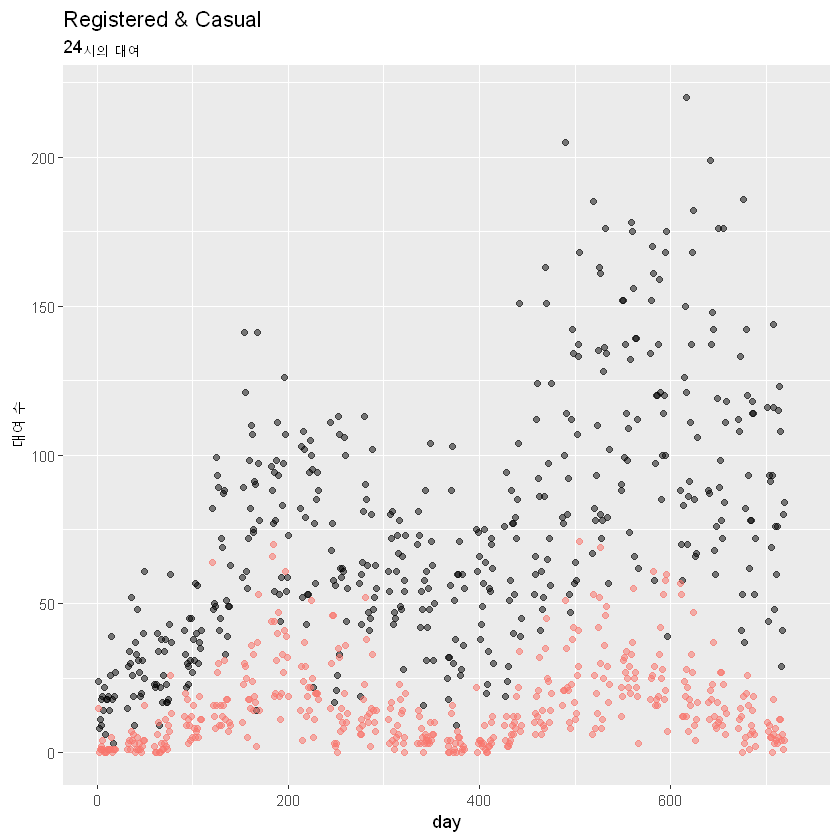

In [22]:
for (i in 1:24) {
    A <- ggplot(data = filter(data, (time == i-1)), aes(x = day, y = registered)) +
            geom_point(alpha = 0.5) + 
            geom_point(aes(x = day, y = casual, colour = 'red', alpha = 0.5)) +
            labs(title = 'Registered & Casual',
                subtitle = paste0(i-0, '시의 대여'),
                y = '대여 수') +
            theme(legend.position = 'none')
    print(A)
}#불필요한 범례 삭제

** 시각에 따른 registered와 casual의 분포도 다르다. 또한 같은 registered일때도 시각에 따라 분포가 다르다.(당연) **  
시각별 분포도 다른 것을 확인할 수 있다.
필요한 변수 추출했으니, datetime 변수 삭제

In [8]:
data$datetime <- NULL
str(data)

'data.frame':	17379 obs. of  13 variables:
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ y         : int  16 40 32 13 1 1 2 3 8 14 ...
 $ time      : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ day       : num  1 1 1 1 1 1 1 1 1 1 ...


### 2. Season

In [16]:
ggplot(data = data, aes(x = factor(season), y = y, color = season)) +
    geom_boxplot() +
    labs(title = 'Boxplot of y',
        sub = 'With season variable',
        x = 'Season')

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

ERROR: Error in png(tf, width, height, "in", pointsize, bg, res, antialias = antialias): png() 장치를 시작할 수 없습니다


plot without title

In [9]:
A <- aov(y ~ season, data = data)

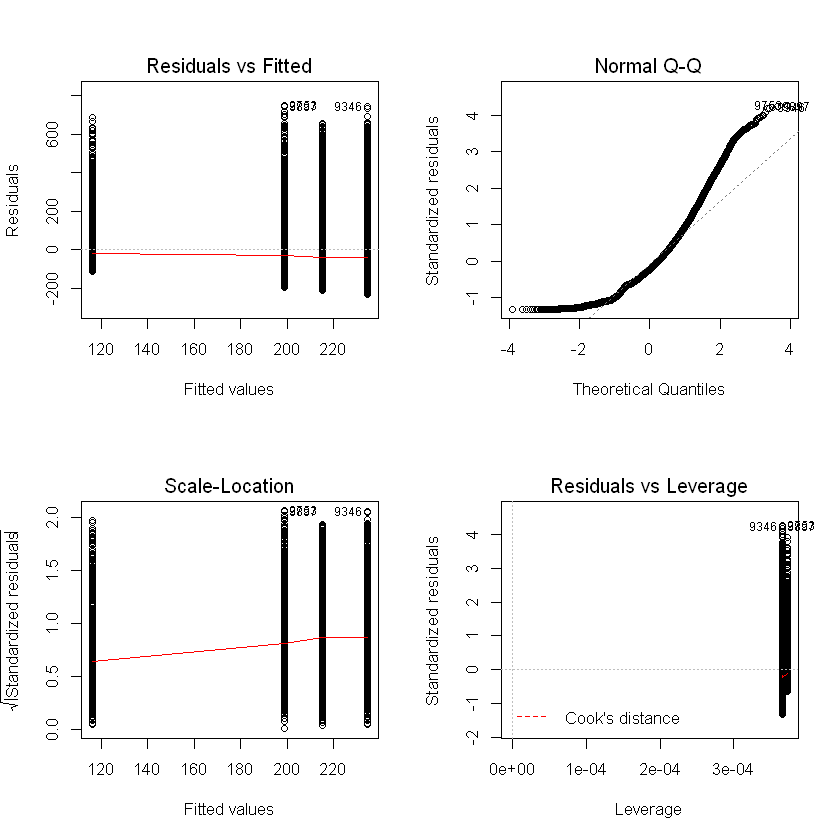

In [11]:
par(mfrow = c(2,2))
plot(A)

In [14]:
summary(A)

               Df    Sum Sq Mean Sq F value Pr(>F)    
season          3  21900832 7300277   236.9 <2e-16 ***
Residuals   10882 335272082   30810                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
6493 observations deleted due to missingness

In [15]:
bartlett.test(y ~ season, data = data)


	Bartlett test of homogeneity of variances

data:  y by season
Bartlett's K-squared = 621.16, df = 3, p-value < 2.2e-16


일단 검정은 하는데... 검정의 타당성은?
기존 가정에 대한 증거 부족

### 3. Holiday

In [28]:
table(data$holiday)


    0     1 
16879   500 

전체 데이터셋에서 휴일의 비율이 압도적으로 적다.

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

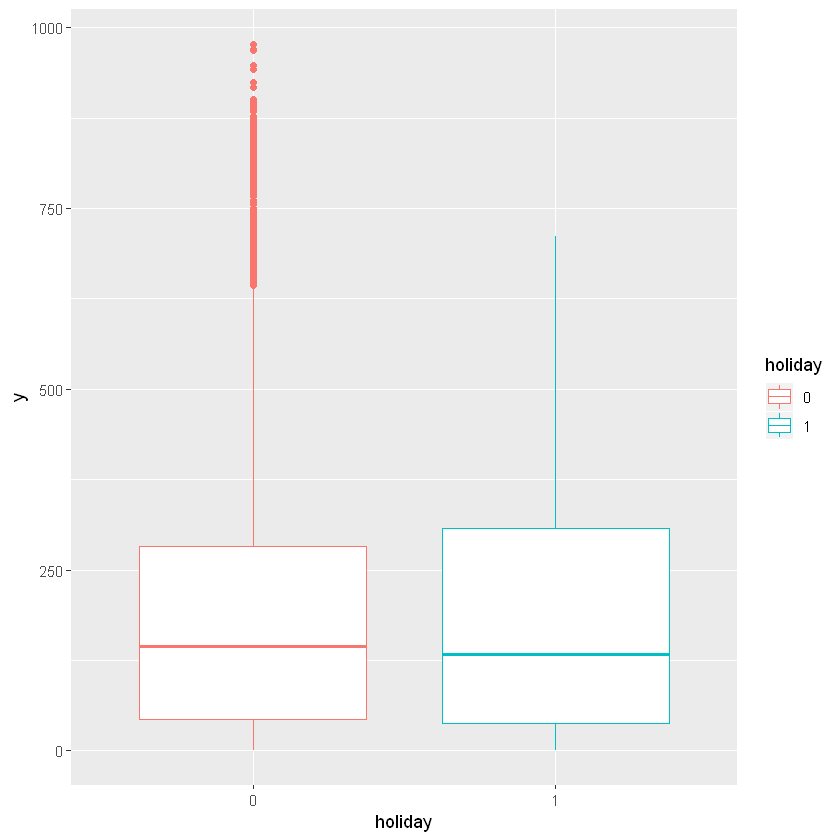

In [18]:
ggplot(data = data, aes(x = holiday, y = y, color = holiday)) +
    geom_boxplot()

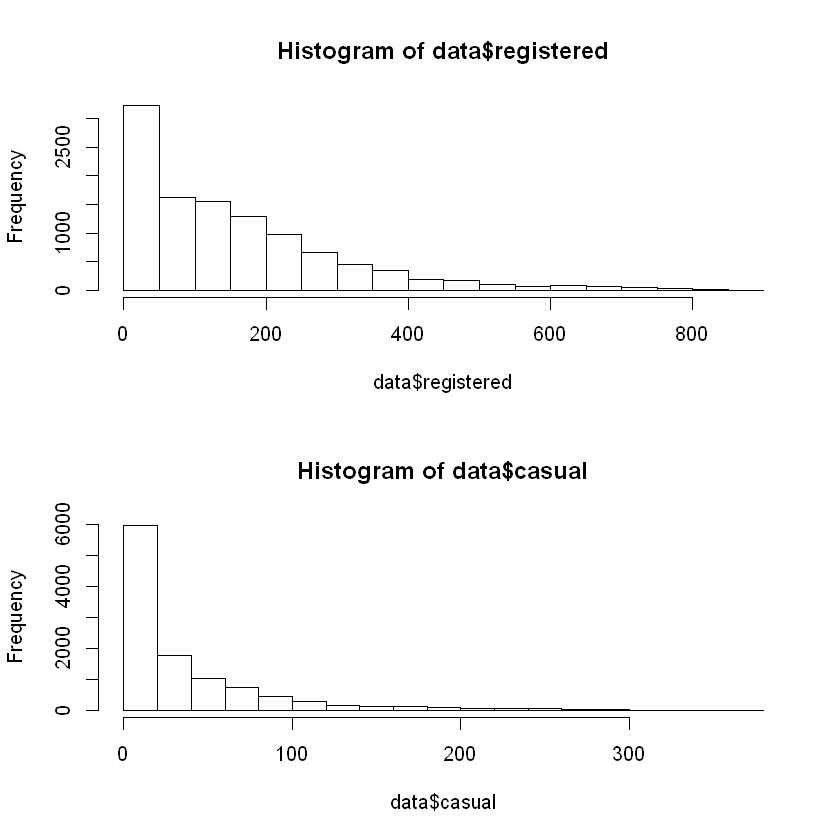

In [33]:
par(mfrow = c(2,1))
hist(data$registered)
hist(data$casual)

분석 및 EDA를 시작하기 앞서, 기존의 datetime변수의 EDA 과정에서 registered와 casual의 분포차이가 확연함을 발견했다.  
따라서 이후의 분석은 Registered를 예측하는 분석과 Casual을 예측하는 분석을 나누어 진행하도록 한다.  
즉, 2번의 데이터분석을 진행!!  
이후의 두개의 합을 최종 Count 값으로 예측한다.  


추가적인 앙상블모형은... 이번분석에서는 제외한다.

# EDA Restart!

## Analysis for predictation of Registered

In [172]:
str(data)

'data.frame':	17379 obs. of  13 variables:
 $ season    : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ workingday: Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ weather   : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 2 1 1 1 1 ...
 $ temp      : num  9.84 9.02 9.02 9.84 9.84 ...
 $ atemp     : num  14.4 13.6 13.6 14.4 14.4 ...
 $ humidity  : int  81 80 80 75 75 75 80 86 75 76 ...
 $ windspeed : num  0 0 0 0 0 ...
 $ casual    : int  3 8 5 3 0 0 2 1 1 8 ...
 $ registered: int  13 32 27 10 1 1 0 2 7 6 ...
 $ y         : int  16 40 32 13 1 1 2 3 8 14 ...
 $ time      : Factor w/ 24 levels "0","1","2","3",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ day       : num  1 1 1 1 1 1 1 1 1 1 ...


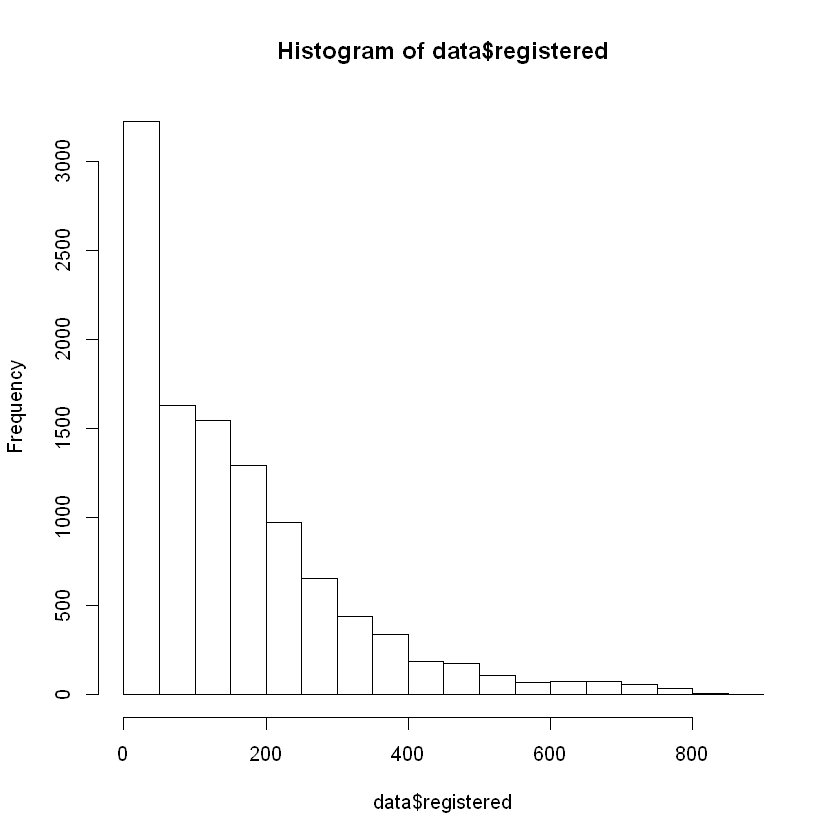

In [194]:
hist(data$registered)

### 1. Season : Factor

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

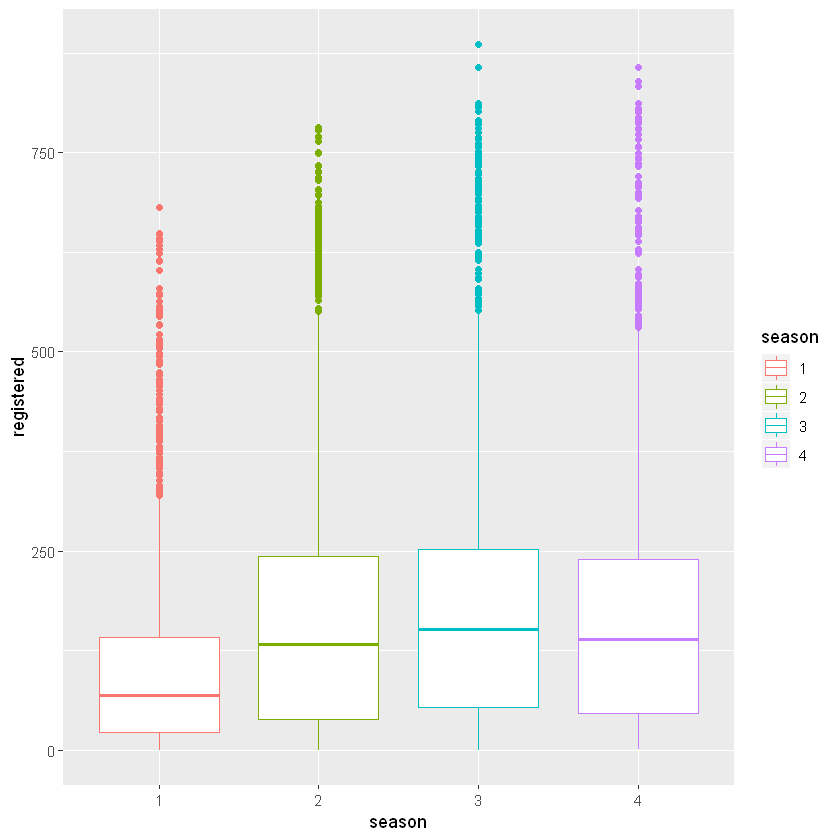

In [19]:
ggplot(data = data, aes(x = season, y = registered, color = season)) +
    geom_boxplot()

In [181]:
# 별다른 특징을 찾지 못함.

In [182]:
summary(aov(registered ~ season, data = data))
# 예의상 진행한 ANOVA 분석 -> 유의하다고 나옴. 즉, 영향을 준다. (분산이 다르다.)

               Df    Sum Sq Mean Sq F value Pr(>F)    
season          3  10990195 3663398     168 <2e-16 ***
Residuals   10882 237327019   21809                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
6493 observations deleted due to missingness

### 2. Holiday : Factor

In [189]:
table(data$holiday)


    0     1 
16879   500 

In [190]:
# 데이터의 수에서 큰 차이를 보인다.

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

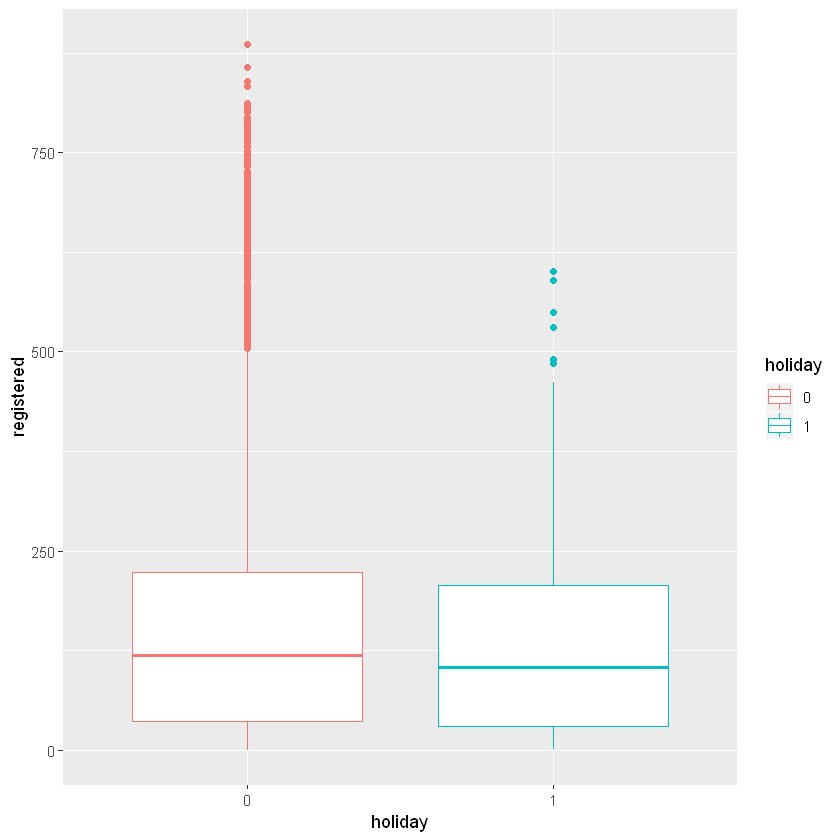

In [21]:
ggplot(data = data, aes(x = holiday, y = registered, color = holiday)) +
    geom_boxplot()

### 3. Workingday : Factor

In [201]:
table(data$workingday)


    0     1 
 5514 11865 

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

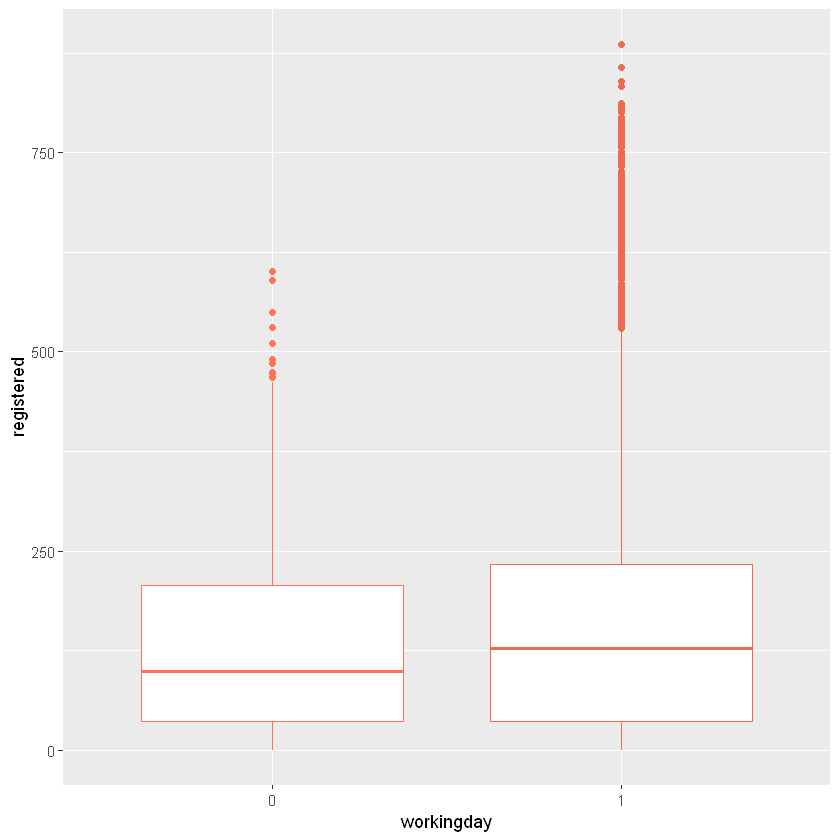

In [193]:
ggplot(data = data, aes(x = workingday, y = registered)) +
    geom_boxplot(color = c('coral1', 'coral2'))

holiday와 굉장히 유사해 보이지만, 비율에 있어서 큰 차이를 보인다.
-> 둘 다 살리는게 낫겠다. 죽일 이유 없음.

### 4. Weather : Factor

In [202]:
table(data$weather)


    1     2     3     4 
11413  4544  1419     3 

팩터레벨이 4인경우, 데이터가 단 3개! 다른 것으로 치환해야 할 것 같다.

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

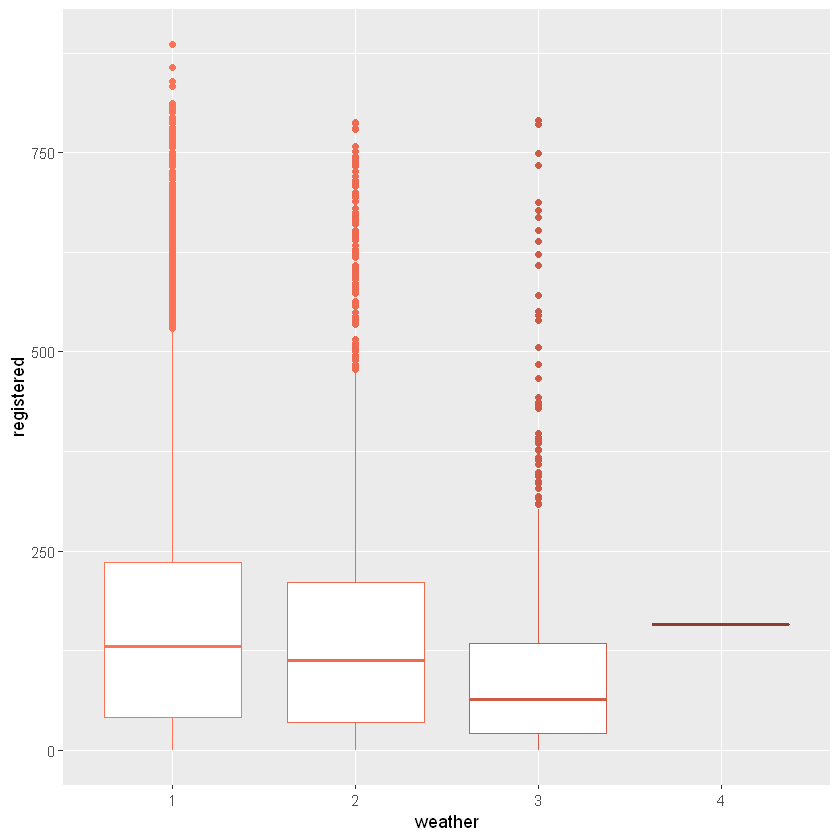

In [204]:
ggplot(data = data, aes(x = weather, y = registered)) +
    geom_boxplot(color = c('coral1', 'coral2', 'coral3', 'coral4'))

In [11]:
#이전값
data[which(data$weather == 4) + 1, ]
data[which(data$weather == 4) - 1, ]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y,time,day
5633,1,0,1,3,8.20,11.365,93,6.0032,3,187,190,19,374
11042,1,0,1,3,8.20,9.090,93,23.9994,NA,NA,NA,17,26
14136,1,0,0,3,5.74,10.605,86,0.0000,NA,NA,NA,2,386


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,y,time,day
5631,1,0,1,3,9.02,13.635,87,0.0000,5,147,152,17,374
11040,1,0,1,3,9.02,9.090,93,31.0009,NA,NA,NA,15,26
14134,1,0,0,3,6.56,7.575,64,15.0013,NA,NA,NA,0,386


모두 3의 날씨 값을 갖는 것을 확인.

In [12]:
data[which(data$weather == 4), 'weather'] <- 3
data$weather <- factor(data$weather) #팩터레벨 4 삭제.

Warning message:
"Removed 6493 rows containing non-finite values (stat_boxplot)."

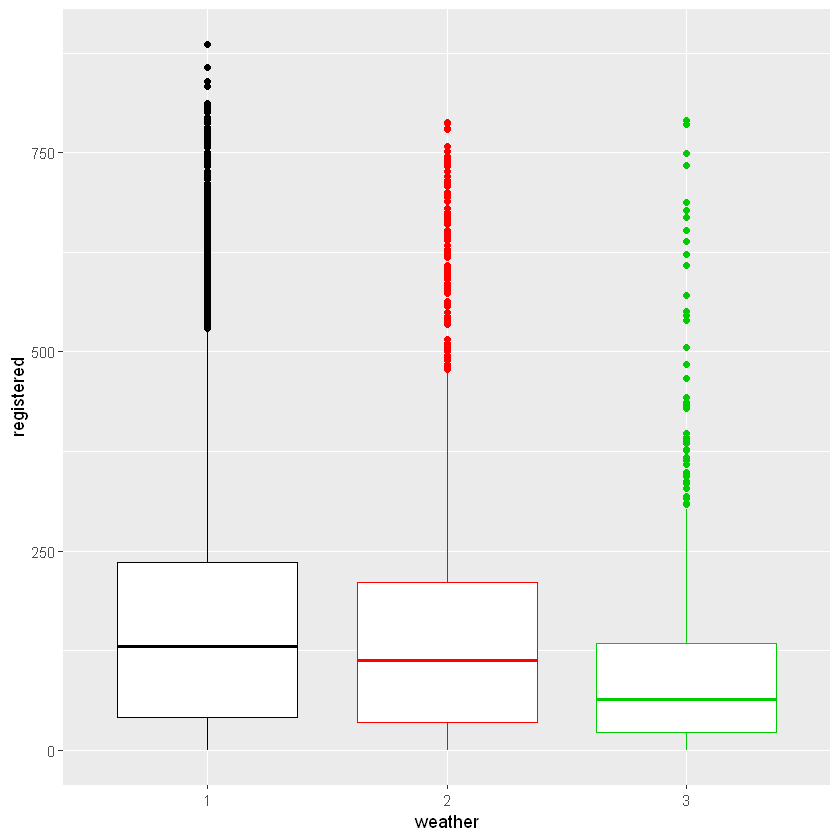

In [13]:
ggplot(data = data, aes(x = weather, y = registered)) +
    geom_boxplot(color = levels(data$weather))

In [231]:
summary(aov(registered ~ weather, data = data))

               Df    Sum Sq Mean Sq F value Pr(>F)    
weather         2   3302096 1651048   73.34 <2e-16 ***
Residuals   10883 245015118   22514                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
6493 observations deleted due to missingness

### 5. Temp : Numeric

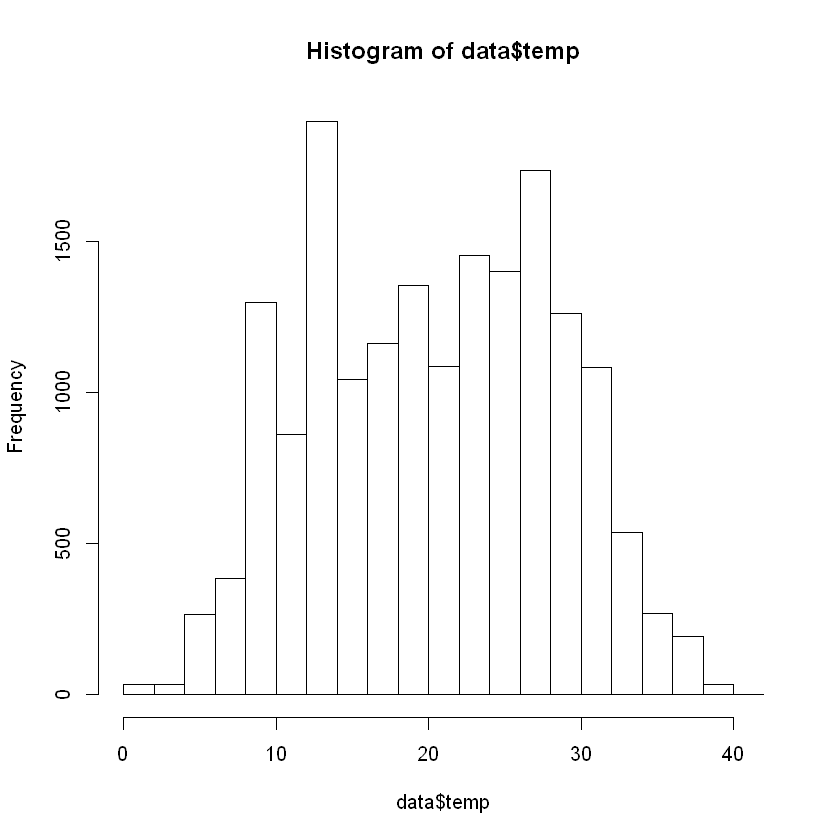

In [237]:
hist(data$temp)

Warning message:
"Removed 6493 rows containing missing values (position_stack)."

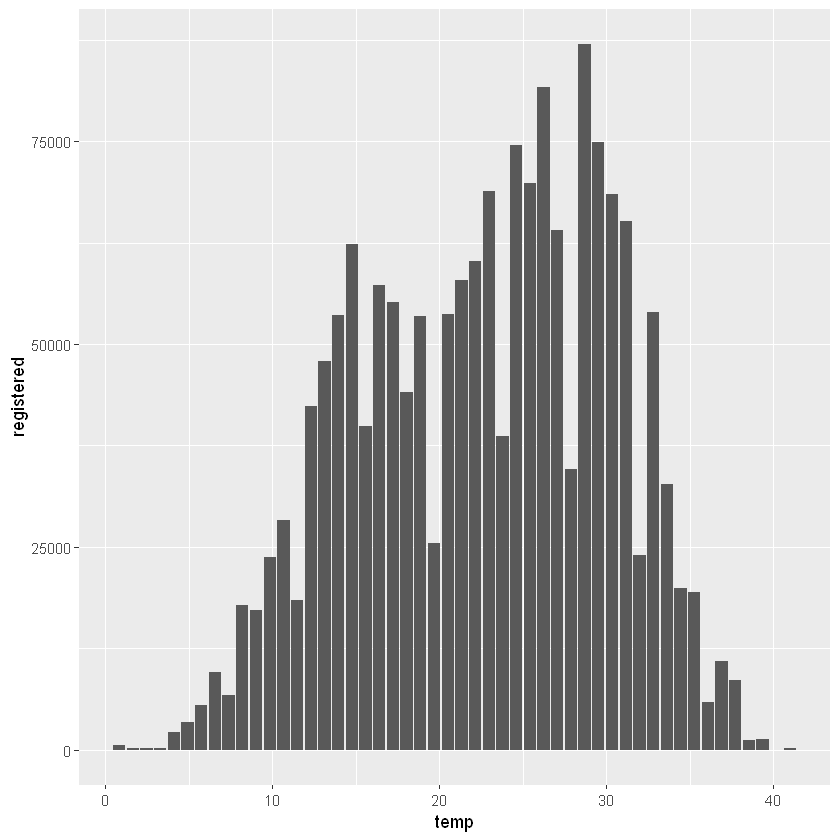

In [245]:
ggplot(data = data, aes(x = temp, y = registered)) +
    geom_bar(stat = 'identity')

In [279]:
X <- data %>% group_by(temp) %>%summarise(registered_mean = mean(registered, na.rm = TRUE))

Warning message:
"Removed 1 rows containing missing values (position_stack)."

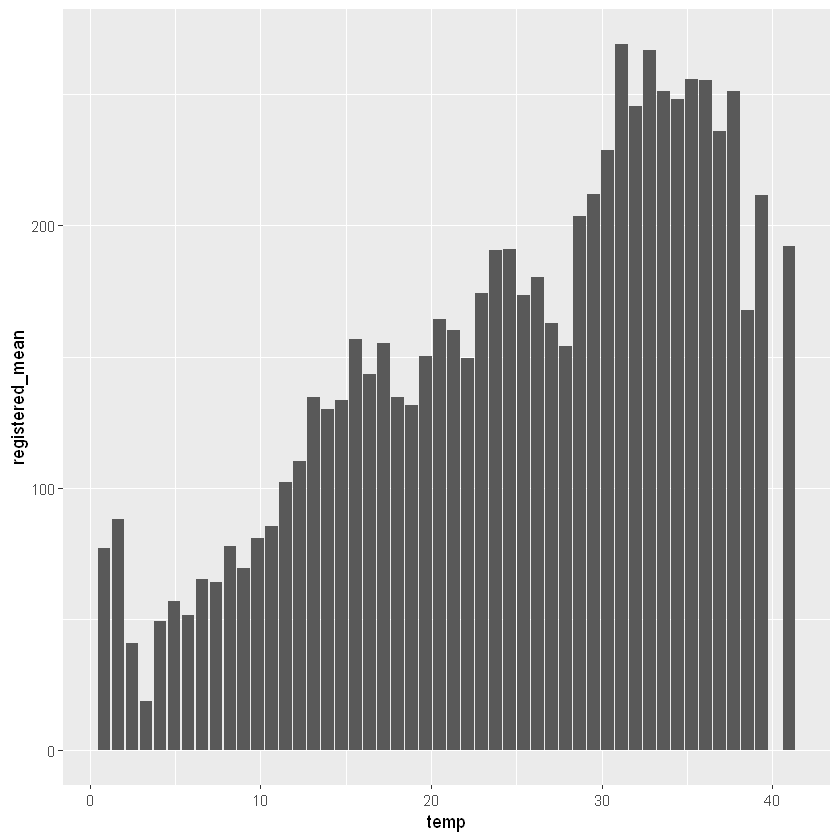

In [280]:
ggplot(data = X, aes(x = temp, y = registered_mean)) +
    geom_bar(stat = 'identity')

상대적으로 온도에 영향을 덜받음..!  
Casual의 경우 온도에 영향을 많이 받음.